## 导入相关包

In [36]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore") 

## 读取数据（训练数据前10000行，测试数据前100条）

In [37]:
train_data = pd.read_csv('./data/train_all.csv',nrows=10000)
test_data = pd.read_csv('./data/test_all.csv',nrows=100)

In [38]:
train_data.head()

,user_id,merchant_id,age_range,gender,user_cnt,seller_nunique,cat_nunique,brand_nunique,item_nunique,time_stamp_nunique,...,embeeding_93,embeeding_94,embeeding_95,embeeding_96,embeeding_97,embeeding_98,embeeding_99,lgb_clf,xgb_clf,label
0,105600.0,1487.0,6.0,1.0,310.0,96.0,37.0,88.0,217.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.933521,0.896583,0.0
1,110976.0,159.0,5.0,0.0,274.0,181.0,70.0,159.0,233.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.945943,0.934458,0.0
2,374400.0,302.0,5.0,1.0,278.0,57.0,59.0,62.0,148.0,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.927698,0.930589,0.0
3,189312.0,1760.0,4.0,0.0,237.0,49.0,35.0,45.0,170.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.917096,0.922519,0.0
4,189312.0,2511.0,4.0,0.0,237.0,49.0,35.0,45.0,170.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.938043,0.936024,0.0


In [39]:
test_data.head()

,user_id,merchant_id,age_range,gender,user_cnt,seller_nunique,cat_nunique,brand_nunique,item_nunique,time_stamp_nunique,...,embeeding_92,embeeding_93,embeeding_94,embeeding_95,embeeding_96,embeeding_97,embeeding_98,embeeding_99,lgb_clf,xgb_clf
0,105600.0,1487.0,6.0,1.0,310.0,96.0,37.0,88.0,217.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.931309,0.838208
1,110976.0,159.0,5.0,0.0,274.0,181.0,70.0,159.0,233.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.937711,0.940051
2,374400.0,302.0,5.0,1.0,278.0,57.0,59.0,62.0,148.0,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.934414,0.935365
3,189312.0,1760.0,4.0,0.0,237.0,49.0,35.0,45.0,170.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.931040,0.932673
4,189312.0,2511.0,4.0,0.0,237.0,49.0,35.0,45.0,170.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.929423,0.929092


## 读取全部数据

In [40]:
# train_data = pd.read_csv('train_all.csv',nrows=None)
# test_data = pd.read_csv('test_all.csv',nrows=None)

In [41]:
train_data.columns

Index(['user_id', 'merchant_id', 'age_range', 'gender', 'user_cnt',
       'seller_nunique', 'cat_nunique', 'brand_nunique', 'item_nunique',
       'time_stamp_nunique',
       ...
       'embeeding_93', 'embeeding_94', 'embeeding_95', 'embeeding_96',
       'embeeding_97', 'embeeding_98', 'embeeding_99', 'lgb_clf', 'xgb_clf',
       'label'],
      dtype='object', length=231)

## 获取训练和测试数据

In [42]:
features_columns = [col for col in train_data.columns if col not in ['user_id','label']]
train = train_data[features_columns].values
test = test_data[features_columns].values
target =train_data['label'].values

## 切分40%数据用于线下验证

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)  

(1200, 229) (1200,)
(800, 229) (800,)


0.92875

## 交叉验证：评估估算器性能

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
scores = cross_val_score(clf, train, target, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) 

[0.93 0.93 0.93 0.93 0.93]
Accuracy: 0.93 (+/- 0.00)


## F1验证

In [45]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
scores = cross_val_score(clf, train, target, cv=5, scoring='f1_macro')
print(scores)  
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.48 0.48 0.48 0.48 0.48]
F1: 0.48 (+/- 0.00)


## ShuffleSplit切分数据

In [46]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf, train, target, cv=cv)  

array([0.92, 0.93, 0.92, 0.94, 0.93])

## 自己写交叉验证

### KFlod切分数据

In [47]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
kf = KFold(n_splits=5)
for k, (train_index, test_index) in enumerate(kf.split(train)):
    X_train, X_test, y_train, y_test = train[train_index], train[test_index], target[train_index], target[test_index]
    clf = clf.fit(X_train, y_train)
    print(k, clf.score(X_test, y_test))

0 0.93
1 0.92
2 0.94
3 0.94
4 0.93


### StratifiedKFold切分数据(label均分)

In [48]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
skf = StratifiedKFold(n_splits=5)
for k, (train_index, test_index) in enumerate(skf.split(train, target)):
    X_train, X_test, y_train, y_test = train[train_index], train[test_index], target[train_index], target[test_index]
    clf = clf.fit(X_train, y_train)
    print(k, clf.score(X_test, y_test))

0 0.9325
1 0.9325
2 0.9325
3 0.9325
4 0.93


## 模型调参

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier


# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.5, random_state=0)

# model 
clf = RandomForestClassifier(n_jobs=-1)

# Set the parameters by cross-validation

tuned_parameters = {
                    'n_estimators': [50, 100, 200]
#                     ,'criterion': ['gini', 'entropy']
#                     ,'max_depth': [2, 5]
#                     ,'max_features': ['log2', 'sqrt', 'int']
#                     ,'bootstrap': [True, False]
#                     ,'warm_start': [True, False]
                    }

scores = ['precision']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(clf, tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_estimators': 50}

Grid scores on development set:

0.466 (+/-0.003) for {'n_estimators': 50}
0.466 (+/-0.002) for {'n_estimators': 100}
0.466 (+/-0.003) for {'n_estimators': 200}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       932
         1.0       0.12      0.01      0.03        68

    accuracy                           0.93      1000
   macro avg       0.53      0.50      0.49      1000
weighted avg       0.88      0.93      0.90      1000




## 模糊矩阵

Confusion matrix, without normalization
[[456   3]
 [ 41   0]]
Normalized confusion matrix
[[0.99 0.01]
 [1.   0.  ]]


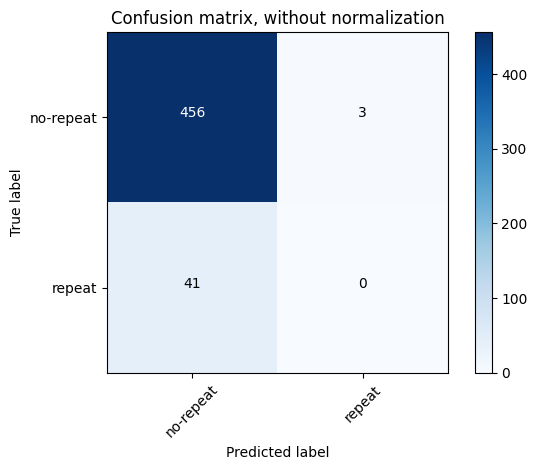

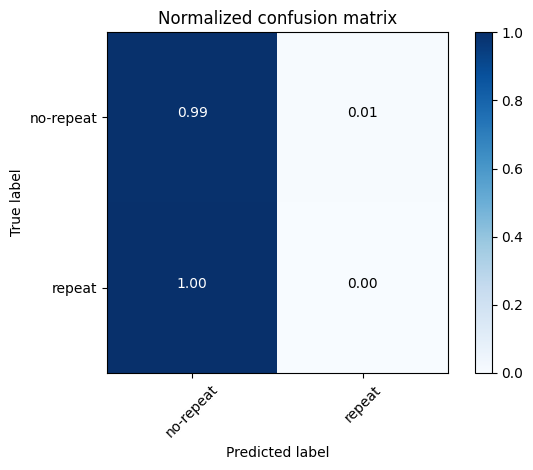

In [50]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# label name
class_names = ['no-repeat', 'repeat']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
clf = RandomForestClassifier(n_jobs=-1)
y_pred = clf.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [51]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# label name
class_names = ['no-repeat', 'repeat']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
clf = RandomForestClassifier(n_jobs=-1)
y_pred = clf.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   no-repeat       0.92      1.00      0.96       459
      repeat       0.33      0.02      0.05        41

    accuracy                           0.92       500
   macro avg       0.63      0.51      0.50       500
weighted avg       0.87      0.92      0.88       500



## 不同的分类模型

### LR 模型

In [52]:
from sklearn.linear_model import LinearRegression

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=0)

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
clf.score(X_test, y_test)

0.918

### KNN 模型

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=0)

clf = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
clf.score(X_test, y_test)

0.906

In [55]:
# clf.predict(X_test)

In [56]:
# clf.predict_proba(X_test)

## GaussianNB 模型

In [57]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=0)

clf = GaussianNB().fit(X_train, y_train)
clf.score(X_test, y_test)

0.504

## tree树模型

In [58]:
from sklearn import tree

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.864

## bagging模型

In [59]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.918

## 随机森林模型

In [60]:
from sklearn.ensemble import RandomForestClassifier

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = clf = RandomForestClassifier(n_estimators=10, max_depth=3, min_samples_split=12, random_state=0)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.918

## ExTree模型

In [61]:
from sklearn.ensemble import ExtraTreesClassifier

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.908

In [62]:
clf.n_features_

229

In [63]:
clf.feature_importances_[:10]

array([0.07, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.02, 0.01])

## AdaBoost模型

In [64]:
from sklearn.ensemble import AdaBoostClassifier

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = AdaBoostClassifier(n_estimators=10)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.918

## GBDT模型

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=0)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.912

## VOTE模型投票

In [66]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
y = target


clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.92 (+/- 0.01) [Logistic Regression]
Accuracy: 0.93 (+/- 0.00) [Random Forest]
Accuracy: 0.49 (+/- 0.03) [naive Bayes]
Accuracy: 0.92 (+/- 0.01) [Ensemble]


## lgb 模型

In [67]:
import lightgbm

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

clf = lightgbm

train_matrix = clf.Dataset(X_train, label=y_train)
test_matrix = clf.Dataset(X_test, label=y_test)
params = {
          'boosting_type': 'gbdt',
          #'boosting_type': 'dart',
          'objective': 'multiclass',
          'metric': 'multi_logloss',
          'min_child_weight': 1.5,
          'num_leaves': 2**5,
          'lambda_l2': 10,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'learning_rate': 0.03,
          'tree_method': 'exact',
          'seed': 2017,
          "num_class": 2,
          'silent': True,
          }
num_round = 10000
#early_stopping_rounds = 100
callbacks=[lightgbm.early_stopping(stopping_rounds=100)]
model = clf.train(params, 
                  train_matrix,
                  num_round,
                  valid_sets=test_matrix,
                  #early_stopping_rounds=early_stopping_rounds
                  callbacks=callbacks
                  )
pre= model.predict(X_valid,num_iteration=model.best_iteration)

[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6627
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 124
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Start training from score -0.068100
[LightGBM] [Info] Start training from score -2.720629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [68]:
print('score : ', np.mean((pre[:,1]>0.5)==y_valid))

score :  0.9275


## xgb 模型

In [69]:
import xgboost

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

clf = xgboost

train_matrix = clf.DMatrix(X_train, label=y_train, missing=-1)
test_matrix = clf.DMatrix(X_test, label=y_test, missing=-1)
z = clf.DMatrix(X_valid, label=y_valid, missing=-1)
params = {'booster': 'gbtree',
          'objective': 'multi:softprob',
          'eval_metric': 'mlogloss',
          'gamma': 1,
          'min_child_weight': 1.5,
          'max_depth': 5,
          'lambda': 100,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'eta': 0.03,
          'tree_method': 'exact',
          'seed': 2017,
          "num_class": 2
          }

num_round = 10000
early_stopping_rounds = 100
watchlist = [(train_matrix, 'train'),
             (test_matrix, 'eval')
             ]

model = clf.train(params,
                  train_matrix,
                  num_boost_round=num_round,
                  evals=watchlist,
                  early_stopping_rounds=early_stopping_rounds
                  )
pre = model.predict(z,ntree_limit=model.best_ntree_limit)

[0]	train-mlogloss:0.67493	eval-mlogloss:0.67523
[1]	train-mlogloss:0.65782	eval-mlogloss:0.65839
[2]	train-mlogloss:0.64136	eval-mlogloss:0.64210
[3]	train-mlogloss:0.62561	eval-mlogloss:0.62645
[4]	train-mlogloss:0.61037	eval-mlogloss:0.61149
[5]	train-mlogloss:0.59608	eval-mlogloss:0.59751
[6]	train-mlogloss:0.58224	eval-mlogloss:0.58400
[7]	train-mlogloss:0.56915	eval-mlogloss:0.57106
[8]	train-mlogloss:0.55639	eval-mlogloss:0.55855
[9]	train-mlogloss:0.54458	eval-mlogloss:0.54696
[10]	train-mlogloss:0.53305	eval-mlogloss:0.53569
[11]	train-mlogloss:0.52191	eval-mlogloss:0.52485
[12]	train-mlogloss:0.51136	eval-mlogloss:0.51460
[13]	train-mlogloss:0.50123	eval-mlogloss:0.50463
[14]	train-mlogloss:0.49148	eval-mlogloss:0.49513
[15]	train-mlogloss:0.48229	eval-mlogloss:0.48624
[16]	train-mlogloss:0.47339	eval-mlogloss:0.47751
[17]	train-mlogloss:0.46491	eval-mlogloss:0.46922
[18]	train-mlogloss:0.45654	eval-mlogloss:0.46132
[19]	train-mlogloss:0.44865	eval-mlogloss:0.45361
[20]	train

[52]	train-mlogloss:0.30205	eval-mlogloss:0.31312
[53]	train-mlogloss:0.29980	eval-mlogloss:0.31109
[54]	train-mlogloss:0.29768	eval-mlogloss:0.30905
[55]	train-mlogloss:0.29559	eval-mlogloss:0.30718
[56]	train-mlogloss:0.29361	eval-mlogloss:0.30526
[57]	train-mlogloss:0.29165	eval-mlogloss:0.30349
[58]	train-mlogloss:0.28989	eval-mlogloss:0.30188
[59]	train-mlogloss:0.28817	eval-mlogloss:0.30022
[60]	train-mlogloss:0.28633	eval-mlogloss:0.29851
[61]	train-mlogloss:0.28460	eval-mlogloss:0.29690
[62]	train-mlogloss:0.28303	eval-mlogloss:0.29550
[63]	train-mlogloss:0.28137	eval-mlogloss:0.29393
[64]	train-mlogloss:0.27978	eval-mlogloss:0.29256
[65]	train-mlogloss:0.27819	eval-mlogloss:0.29115
[66]	train-mlogloss:0.27665	eval-mlogloss:0.28980
[67]	train-mlogloss:0.27516	eval-mlogloss:0.28856
[68]	train-mlogloss:0.27368	eval-mlogloss:0.28732
[69]	train-mlogloss:0.27231	eval-mlogloss:0.28620
[70]	train-mlogloss:0.27103	eval-mlogloss:0.28509
[71]	train-mlogloss:0.26974	eval-mlogloss:0.28391


In [70]:
print('score : ', np.mean((pre[:,1]>0.3)==y_valid))

score :  0.9275


# 自己封装模型

## Stacking,Bootstrap,Bagging技术实践

In [71]:
"""
    导入相关包
"""
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [72]:
class SBBTree():
    """
        SBBTree
        Stacking,Bootstap,Bagging
    """
    def __init__(
                    self, 
                    params,
                    stacking_num,
                    bagging_num,
                    bagging_test_size,
                    num_boost_round,
                    #early_stopping_rounds
                    callbacks
                ):
        """
            Initializes the SBBTree.
            Args:
              params : lgb params.
              stacking_num : k_flod stacking.
              bagging_num : bootstrap num.
              bagging_test_size : bootstrap sample rate.
              num_boost_round : boost num.
              early_stopping_rounds : early_stopping_rounds.
        """
        self.params = params
        self.stacking_num = stacking_num
        self.bagging_num = bagging_num
        self.bagging_test_size = bagging_test_size
        self.num_boost_round = num_boost_round
        #self.early_stopping_rounds = early_stopping_rounds
        self.callbacks = callbacks

        self.model = lgb
        self.stacking_model = []
        self.bagging_model = []

    def fit(self, X, y):
        """ fit model. """
        if self.stacking_num > 1:
            layer_train = np.zeros((X.shape[0], 2))
            self.SK = StratifiedKFold(n_splits=self.stacking_num, shuffle=True, random_state=1)
            for k,(train_index, test_index) in enumerate(self.SK.split(X, y)):
                X_train = X[train_index]
                y_train = y[train_index]
                X_test = X[test_index]
                y_test = y[test_index]

                lgb_train = lgb.Dataset(X_train, y_train)
                lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

                gbm = lgb.train(self.params,
                            lgb_train,
                            num_boost_round=self.num_boost_round,
                            valid_sets=lgb_eval,
                            #early_stopping_rounds=self.early_stopping_rounds
                            callbacks=self.callbacks
                            )

                self.stacking_model.append(gbm)

                pred_y = gbm.predict(X_test, num_iteration=gbm.best_iteration)
                layer_train[test_index, 1] = pred_y

            X = np.hstack((X, layer_train[:,1].reshape((-1,1)))) 
        else:
            pass
        for bn in range(self.bagging_num):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.bagging_test_size, random_state=bn)

            lgb_train = lgb.Dataset(X_train, y_train)
            lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

            gbm = lgb.train(self.params,
                        lgb_train,
                        num_boost_round=10000,
                        valid_sets=lgb_eval,
                        #early_stopping_rounds=200
                        callbacks=[lightgbm.early_stopping(stopping_rounds=200)]
                        )

            self.bagging_model.append(gbm)

    def predict(self, X_pred):
        """ predict test data. """
        if self.stacking_num > 1:
            test_pred = np.zeros((X_pred.shape[0], self.stacking_num))
            for sn,gbm in enumerate(self.stacking_model):
                pred = gbm.predict(X_pred, num_iteration=gbm.best_iteration)
                test_pred[:, sn] = pred
            X_pred = np.hstack((X_pred, test_pred.mean(axis=1).reshape((-1,1))))  
        else:
            pass 
        for bn,gbm in enumerate(self.bagging_model):
            pred = gbm.predict(X_pred, num_iteration=gbm.best_iteration)
            if bn == 0:
                pred_out=pred
            else:
                pred_out+=pred
        return pred_out/self.bagging_num

## 测试自己封装的模型类

In [73]:
"""
    TEST CODE
"""
from sklearn.datasets import make_classification
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_gaussian_quantiles
from sklearn import metrics
from sklearn.metrics import f1_score
# X, y = make_classification(n_samples=1000, n_features=25, n_clusters_per_class=1, n_informative=15, random_state=1)
X, y = make_gaussian_quantiles(mean=None, cov=1.0, n_samples=1000, n_features=50, n_classes=2, shuffle=True, random_state=2)
# data = load_breast_cancer()
# X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 9,
        'learning_rate': 0.03,
        'feature_fraction_seed': 2,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_data': 20,
        'min_hessian': 1,
        'verbose': -1,
        'silent': 0
        }
# test 1
model = SBBTree(params=params, stacking_num=2, bagging_num=1,  bagging_test_size=0.33, num_boost_round=10000, callbacks=[lightgbm.early_stopping(stopping_rounds=200)])
model.fit(X,y)
X_pred = X[0].reshape((1,-1))
pred=model.predict(X_pred)
print('pred')
print(pred)
print('TEST 1 ok')


# test 1
model = SBBTree(params, stacking_num=1, bagging_num=1, bagging_test_size=0.33, num_boost_round=10000, callbacks=[lightgbm.early_stopping(stopping_rounds=200)])
model.fit(X_train,y_train)
pred1=model.predict(X_test)

# test 2 
model = SBBTree(params, stacking_num=1, bagging_num=3, bagging_test_size=0.33, num_boost_round=10000, callbacks=[lightgbm.early_stopping(stopping_rounds=200)])
model.fit(X_train,y_train)
pred2=model.predict(X_test)

# test 3 
model = SBBTree(params, stacking_num=5, bagging_num=1, bagging_test_size=0.33, num_boost_round=10000, callbacks=[lightgbm.early_stopping(stopping_rounds=200)])
model.fit(X_train,y_train)
pred3=model.predict(X_test)

# test 4 
model = SBBTree(params, stacking_num=5, bagging_num=3, bagging_test_size=0.33, num_boost_round=10000, callbacks=[lightgbm.early_stopping(stopping_rounds=200)])
model.fit(X_train,y_train)
pred4=model.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test+1, pred1, pos_label=2)
print('auc: ',metrics.auc(fpr, tpr))

fpr, tpr, thresholds = metrics.roc_curve(y_test+1, pred2, pos_label=2)
print('auc: ',metrics.auc(fpr, tpr))

fpr, tpr, thresholds = metrics.roc_curve(y_test+1, pred3, pos_label=2)
print('auc: ',metrics.auc(fpr, tpr))

fpr, tpr, thresholds = metrics.roc_curve(y_test+1, pred4, pos_label=2)
print('auc: ',metrics.auc(fpr, tpr))


# auc:  0.7281621243885396
# auc:  0.7710471146419509
# auc:  0.7894369046305492
# auc:  0.8084519474787597

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[565]	valid_0's auc: 0.761952
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[598]	valid_0's auc: 0.789344
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[480]	valid_0's auc: 0.808629
pred
[0.12]
TEST 1 ok
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[259]	valid_0's auc: 0.75051
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[259]	valid_0's auc: 0.75051
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[401]	valid_0's auc: 0.769037
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[368]	valid_0's auc: 0.766177
Training until validation scores don't improve for 200 rounds
Early stopping, best iteratio

## 天猫复购场景实战

## 读取特征数据

In [74]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_data = pd.read_csv('./data/train_all.csv',nrows=10000)
test_data = pd.read_csv('./data/test_all.csv',nrows=100)

features_columns = [col for col in train_data.columns if col not in ['user_id','label']]
train = train_data[features_columns].values
test = test_data[features_columns].values
target =train_data['label'].values

## 设置模型参数

In [75]:
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 9,
        'learning_rate': 0.03,
        'feature_fraction_seed': 2,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_data': 20,
        'min_hessian': 1,
        'verbose': -1,
        'silent': 0
        }

model = SBBTree(params=params,
                stacking_num=5,
                bagging_num=3,
                bagging_test_size=0.33,
                num_boost_round=10000,
                #early_stopping_rounds=200
                callbacks=[lightgbm.early_stopping(stopping_rounds=200)]
                )

## 模型训练

In [76]:
model.fit(train, target)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.651375
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1375]	valid_0's auc: 0.742925
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[805]	valid_0's auc: 0.671731
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.725797
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	valid_0's auc: 0.56442
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1177]	valid_0's auc: 0.668016
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[214]	valid_0's auc: 0.616207
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	valid_0's au

## 预测结果

In [77]:
pred = model.predict(test)
df_out = pd.DataFrame()
df_out['user_id'] = test_data['user_id'].astype(int)
df_out['predict_prob'] = pred
df_out.head()

,user_id,predict_prob
0,105600,0.034984
1,110976,0.030769
2,374400,0.038566
3,189312,0.042045
4,189312,0.038282


## 保存结果

In [78]:
"""
    保留数据头，不保存index
"""
df_out.to_csv('./data/df_out.csv',header=True,index=False)
print('save OK!')

save OK!


In [79]:
# !ls

In [80]:
# !head df_out.csv